In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow_datasets as tfds
import random

from data_processing import create_training_split, df_training_split, create_df_3d, create_window_closed_loop, add_new_pred, compute_lyapunov_time_arr
from lstm_model import build_open_loop_lstm, load_open_loop_lstm

## DATA
- Data is generated in Lorenz_data_creation.ipynb
- 4D Data (t,x,y,z)
- Data is normalized with respect to max(abs())

In [2]:
mydf = np.genfromtxt('CSV/lorenz_normalized.csv',delimiter=',')
time = mydf[0, :]
mydf = mydf[1:, :]
print("Shape of discrete time step array ", time.shape)
print("Shape of solution array: ", mydf.shape)

Shape of discrete time step array  (10000,)
Shape of solution array:  (3, 10000)


## Data Preprocessing
- training/ testation split 70/30

In [3]:
df_train, df_test = df_training_split(mydf)
time_train, time_test = create_training_split(time, ratio=0.7)
x_train, x_test = create_training_split(mydf[0,:], ratio=0.7)
y_train, y_test = create_training_split(mydf[1, :], ratio=0.7)
z_train, z_test = create_training_split(mydf[2, :], ratio=0.7)

### Windowing
- split the sequential data into windows to be fed into the network in batches
- Batch size of 32, Window size of 50, 3D entries

In [4]:
# Transposition needed for windowing of 3D data
df_train_transposed = df_train.transpose()
df_test_transposed = df_test.transpose()

In [5]:
window_size=50
batch_size=32
shuffle_buffer_size = df_train.shape[0]
train_dataset = create_df_3d(df_train_transposed, window_size, batch_size, shuffle_buffer_size)
test_dataset = create_df_3d(df_test_transposed, window_size, batch_size, 1)

## MODEL & TRAINING
- build LSTM (same dim as window = 50)
- train LSTM (epochs?)

In [6]:
for example_inputs, example_labels in train_dataset.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 50, 3)
Labels shape (batch, time, features): (32, 3)


2022-02-01 13:53:36.933921: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50
218/218 [==============================] - 3s 12ms/step - loss: 0.0228
Epoch 2/50
218/218 [==============================] - 3s 12ms/step - loss: 7.7935e-04
Epoch 3/50
218/218 [==============================] - 3s 12ms/step - loss: 0.0063
Epoch 4/50
218/218 [==============================] - 3s 12ms/step - loss: 4.9843e-04
Epoch 5/50
218/218 [==============================] - 3s 12ms/step - loss: 1.0170e-04
Epoch 6/50
218/218 [==============================] - 3s 12ms/step - loss: 8.5492e-05
Epoch 7/50
218/218 [==============================] - 3s 12ms/step - loss: 7.5632e-05
Epoch 8/50
218/218 [==============================] - 3s 12ms/step - loss: 9.8127e-05
Epoch 9/50
218/218 [==============================] - 3s 12ms/step - loss: 9.8996e-05
Epoch 10/50
218/218 [==============================] - 3s 12ms/step - loss: 1.0174e-04
Epoch 11/50
218/218 [==============================] - 3s 12ms/step - loss: 1.5483e-04
Epoch 12/50
218/218 [==============================] - 3s 12

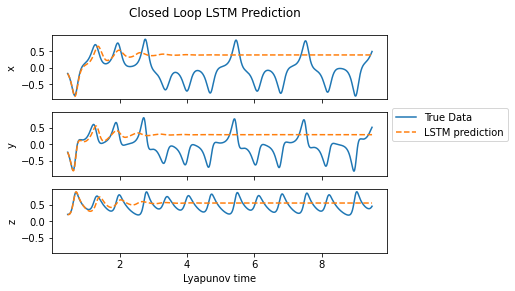

Epoch 1/50
218/218 [==============================] - 3s 12ms/step - loss: 3.9565e-05
Epoch 2/50
218/218 [==============================] - 3s 12ms/step - loss: 7.3895e-05
Epoch 3/50
218/218 [==============================] - 3s 12ms/step - loss: 2.9545e-05
Epoch 4/50
218/218 [==============================] - 3s 12ms/step - loss: 6.7114e-05
Epoch 5/50
218/218 [==============================] - 3s 12ms/step - loss: 2.7365e-04
Epoch 6/50
218/218 [==============================] - 3s 12ms/step - loss: 1.4584e-04
Epoch 7/50
218/218 [==============================] - 3s 12ms/step - loss: 4.6110e-05
Epoch 8/50
218/218 [==============================] - 3s 12ms/step - loss: 2.4737e-05
Epoch 9/50
218/218 [==============================] - 3s 12ms/step - loss: 1.5607e-05
Epoch 10/50
218/218 [==============================] - 3s 12ms/step - loss: 1.2904e-04
Epoch 11/50
218/218 [==============================] - 3s 12ms/step - loss: 1.0106e-04
Epoch 12/50
218/218 [==============================]

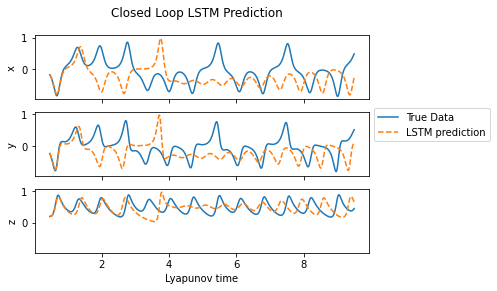

Epoch 1/50
218/218 [==============================] - 3s 12ms/step - loss: 5.9890e-05
Epoch 2/50
218/218 [==============================] - 3s 12ms/step - loss: 4.1220e-05
Epoch 3/50
218/218 [==============================] - 3s 12ms/step - loss: 3.8392e-05
Epoch 4/50
218/218 [==============================] - 3s 12ms/step - loss: 5.9166e-05
Epoch 5/50
218/218 [==============================] - 3s 12ms/step - loss: 4.0943e-05
Epoch 6/50
218/218 [==============================] - 3s 12ms/step - loss: 4.6302e-05
Epoch 7/50
218/218 [==============================] - 3s 12ms/step - loss: 9.8386e-05
Epoch 8/50
218/218 [==============================] - 3s 12ms/step - loss: 3.5239e-05
Epoch 9/50
218/218 [==============================] - 3s 12ms/step - loss: 1.1639e-05
Epoch 10/50
218/218 [==============================] - 3s 12ms/step - loss: 1.8808e-05
Epoch 11/50
218/218 [==============================] - 3s 12ms/step - loss: 5.0987e-05
Epoch 12/50
218/218 [==============================]

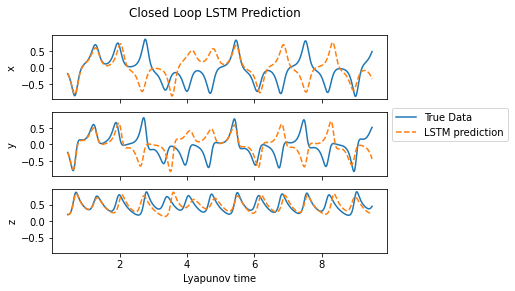

Epoch 1/50
218/218 [==============================] - 3s 12ms/step - loss: 3.1990e-05
Epoch 2/50
218/218 [==============================] - 3s 12ms/step - loss: 2.1740e-05
Epoch 3/50
218/218 [==============================] - 2s 11ms/step - loss: 2.6291e-05
Epoch 4/50
218/218 [==============================] - 3s 11ms/step - loss: 5.0420e-05
Epoch 5/50
218/218 [==============================] - 3s 12ms/step - loss: 2.0810e-05
Epoch 6/50
218/218 [==============================] - 3s 12ms/step - loss: 4.9076e-05
Epoch 7/50
218/218 [==============================] - 2s 11ms/step - loss: 4.1281e-05
Epoch 8/50
218/218 [==============================] - 3s 12ms/step - loss: 2.2618e-05
Epoch 9/50
218/218 [==============================] - 3s 12ms/step - loss: 1.7603e-05
Epoch 10/50
218/218 [==============================] - 3s 12ms/step - loss: 1.9071e-05
Epoch 11/50
218/218 [==============================] - 3s 12ms/step - loss: 7.5131e-06
Epoch 12/50
218/218 [==============================]

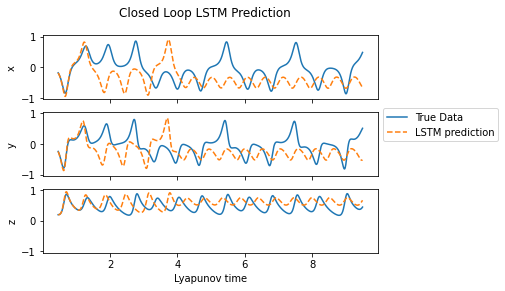

Epoch 1/50
218/218 [==============================] - 3s 12ms/step - loss: 4.0765e-05
Epoch 2/50
218/218 [==============================] - 3s 12ms/step - loss: 3.3453e-05
Epoch 3/50
218/218 [==============================] - 3s 12ms/step - loss: 1.1852e-05
Epoch 4/50
218/218 [==============================] - 3s 12ms/step - loss: 1.8868e-05
Epoch 5/50
218/218 [==============================] - 3s 12ms/step - loss: 2.3850e-05
Epoch 6/50
218/218 [==============================] - 3s 12ms/step - loss: 2.2414e-05
Epoch 7/50
218/218 [==============================] - 3s 12ms/step - loss: 2.8923e-05
Epoch 8/50
218/218 [==============================] - 3s 12ms/step - loss: 2.0687e-05
Epoch 9/50
218/218 [==============================] - 3s 12ms/step - loss: 2.7677e-05
Epoch 10/50
218/218 [==============================] - 3s 12ms/step - loss: 1.9620e-05
Epoch 11/50
218/218 [==============================] - 3s 12ms/step - loss: 2.6874e-05
Epoch 12/50
218/218 [==============================]

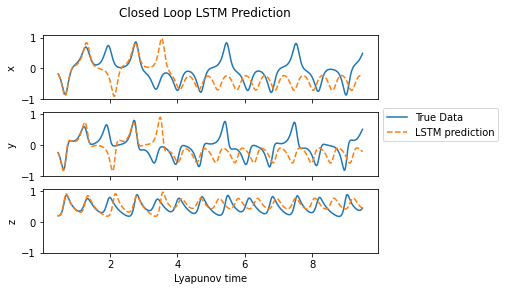

Epoch 1/50
218/218 [==============================] - 3s 12ms/step - loss: 2.5362e-05
Epoch 2/50
218/218 [==============================] - 3s 12ms/step - loss: 1.8491e-05
Epoch 3/50
218/218 [==============================] - 3s 12ms/step - loss: 2.6032e-05
Epoch 4/50
218/218 [==============================] - 3s 12ms/step - loss: 1.5742e-05
Epoch 5/50
218/218 [==============================] - 3s 12ms/step - loss: 1.1413e-05
Epoch 6/50
218/218 [==============================] - 3s 12ms/step - loss: 2.1276e-05
Epoch 7/50
218/218 [==============================] - 3s 12ms/step - loss: 4.6745e-05
Epoch 8/50
218/218 [==============================] - 3s 12ms/step - loss: 2.6163e-05
Epoch 9/50
218/218 [==============================] - 3s 12ms/step - loss: 6.9463e-06
Epoch 10/50
218/218 [==============================] - 3s 12ms/step - loss: 3.7201e-06
Epoch 11/50
218/218 [==============================] - 3s 12ms/step - loss: 1.1553e-05
Epoch 12/50
218/218 [==============================]

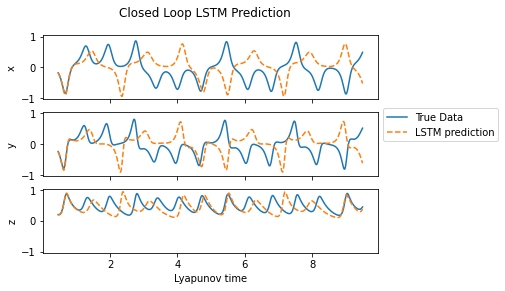

Epoch 1/50
218/218 [==============================] - 3s 12ms/step - loss: 1.7807e-05
Epoch 2/50
218/218 [==============================] - 3s 12ms/step - loss: 8.7992e-06
Epoch 3/50
218/218 [==============================] - 3s 12ms/step - loss: 7.3713e-06
Epoch 4/50
218/218 [==============================] - 3s 12ms/step - loss: 1.0847e-05
Epoch 5/50
218/218 [==============================] - 3s 12ms/step - loss: 1.9186e-05
Epoch 6/50
218/218 [==============================] - 3s 12ms/step - loss: 2.4417e-05
Epoch 7/50
218/218 [==============================] - 3s 12ms/step - loss: 3.0264e-05
Epoch 8/50
218/218 [==============================] - 3s 12ms/step - loss: 1.9567e-05
Epoch 9/50
218/218 [==============================] - 3s 12ms/step - loss: 6.9253e-06
Epoch 10/50
 53/218 [======>.......................] - ETA: 2s - loss: 3.3307e-06

KeyboardInterrupt: 

In [35]:
def build_open_loop_lstm():
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(50, activation='relu', name='LSTM_1'),
        tf.keras.layers.Dense(3, name='Dense_1')
        ])
    optimizer = tf.keras.optimizers.Adam()
    loss = tf.keras.losses.MeanSquaredError()
    model.compile(loss='mse', optimizer='adam')
    return model

model_oloop = build_open_loop_lstm()
for i in range(0, 10):
    model_oloop.fit(train_dataset, epochs=50, batch_size=batch_size)
    plot_closed_loop_lya(model_oloop)
model_oloop.summary()

In [9]:
model_checkpoint = 'oloop_lstm/200_epoch_cp'

In [84]:
# Save the weights
#model_oloop.save_weights(model_checkpoint)

# Create a new model instance
model = build_open_loop_lstm()

# Restore the weights
model.load_weights(model_checkpoint)
model.fit(train_dataset, epochs=1, batch_size=batch_size)

218/218 [==============================] - 3s 12ms/step - loss: 1.5476e-05


## EVALUATE
Use the LSTM model to predict and plot the testation data. 

In [8]:
def create_window_closed_loop(test_data, iteration, pred=np.array([])):
    if iteration == 0:
        print("no network prediction yet")
        return test_data[:50, :].reshape(1, 50, 3)
    if iteration < 50:
        n_pred = pred.shape[0]
        idx_test_entries = iteration + 50 - n_pred  # end index of entries from the test data, 
        test_data = test_data[iteration: idx_test_entries , :]
        return np.append(test_data, pred, axis=0).reshape(1, 50, 3)
    else:
        return pred[-50:,:].reshape(1, 50, 3)

def add_new_pred(pred_old, pred_new):
    return np.append(pred_old,pred_new, axis=0)

In [9]:
def closed_loop_loss(true_val, pred_val):
    return tf.keras.metrics.mean_squared_error(true_val, pred_val)

In [10]:
def select_random_window_with_label(df_transposed, n_windows):
    idx = random.sample(range(len(df_transposed)-50-1), n_windows)
    #window_list =[]
    window_list = [df_transposed[i:i+50, :].reshape(1, 50, 3) for i in idx]
    label_list = [df_transposed[i+51, :].reshape(1, 3) for i in idx]
    return window_list, label_list, idx

def add_cloop_prediction(df_transposed, idx, predictions):
    window_list = np.array([np.append(df_train.transpose()[idx[i]+1:idx[i]+50, :], predictions[i, :].reshape(1,3), axis=0).reshape(50, 3) for i in range(0,len(idx))])
    label_list = np.array([df_transposed[i+52, :] for i in idx])
    return window_list, label_list

In [11]:
test_window = create_window_closed_loop(df_test.transpose(), 10)  # np.append(df_train[:, -50:], df_test, axis=1)
predictions = model.predict(test_window)
for iteration in range(1,50):
    test_window = create_window_closed_loop(df_test.transpose(), iteration, predictions)
    new_pred = model.predict(test_window)
    #new_loss = closed_loop_loss(df_test[:, iteration+1], new_pred)
    #print(new_loss)
    #model.compile(loss=new_loss, optimizer='adam')
    predictions = add_new_pred(predictions, new_pred)
predictions.shape

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [ ]:

test_window = create_window_closed_loop(df_test.transpose(), 0) # np.append(df_train[:, -50:], df_test, axis=1)
predictions = model.predict(test_window)
predictions.shape

no network prediction yet


(1, 3)

In [ ]:
cloop_windows, cloop_label = add_cloop_prediction(df_train.transpose(), idx, predictions)
np.array(cloop_label).shape

(10, 3)

In [ ]:
for example_inputs, example_labels in my_ds.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (50, 3)
Labels shape (batch, time, features): (3,)


In [91]:
cloop_size = 10
test_window, labels, idx = select_random_window_with_label(df_train.transpose(), cloop_size) # np.append(df_train[:, -50:], df_test, axis=1)
predictions = model.predict(test_window)
for iteration in range(1,cloop_size):
    new_pred = model.predict(test_window[iteration])
    predictions = add_new_pred(predictions, new_pred)
print(predictions.shape)
cloop_windows, cloop_label = add_cloop_prediction(df_train.transpose(), idx, predictions)
print(np.array(cloop_windows).shape, cloop_label.shape)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.MeanSquaredError()
model.compile(loss='mse', optimizer='adam')
model.fit(cloop_windows, cloop_label, epochs=10, batch_size=32)

Consider rewriting this model with the Functional API.
(10, 3)
(10, 50, 3) (10, 3)
Epoch 1/10
1/1 [==============================] - 1s 643ms/step - loss: 4.2471e-04
Epoch 2/10
1/1 [==============================] - 0s 18ms/step - loss: 2.5446e-04
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 1.8947e-04
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 1.7272e-04
Epoch 5/10
1/1 [==============================] - 0s 10ms/step - loss: 1.6146e-04
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 1.4561e-04
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 1.2689e-04
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 1.0931e-04
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 9.4609e-05
Epoch 10/10
1/1 [==============================] - 0s 10ms/step - loss: 8.0795e-05


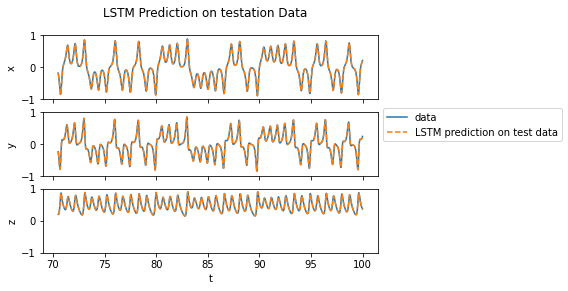

In [17]:
forecast=model.predict(test_dataset)
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, facecolor="white")#, figsize=(15, 15))
fig.suptitle('LSTM Prediction on testation Data')
ax1.plot(time_test[50:],x_test[50:], label='data')
ax1.plot(time_test[50:],forecast[:,0],'--', label='RNN prediction on test data')
ax1.set_ylabel('x')
ax2.plot(time_test[50:],y_test[50:], label='data')
ax2.plot(time_test[50:],forecast[:,1],'--', label='RNN prediction on test data')
ax2.set_ylabel('y')
ax3.plot(time_test[50:],z_test[50:], label='data')
ax3.plot(time_test[50:],forecast[:,2],'--', label='LSTM prediction on test data')
ax3.set_ylabel('z')
ax3.set_xlabel('t')
ax3.set_ylim(-1,1)
ax3.legend(loc='center left', bbox_to_anchor=(1, 2.0))
#fig.savefig(testation_filepath, dpi=1000, facecolor="w", bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


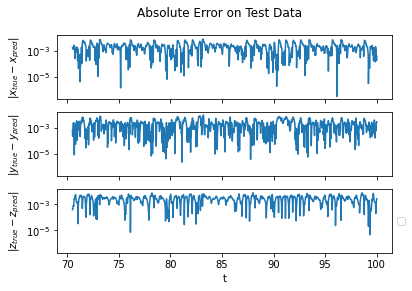

In [19]:
err = df_test.transpose()[50:, :] - forecast
abs_error = np.abs(df_test.transpose()[50:, :] - forecast)

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, facecolor='w')#, figsize=(15, 15))
fig.suptitle('Absolute Error on Test Data')
ax1.plot(time_test[50:], abs_error[:, 0])
ax1.set_ylabel(r'$|x_{true}-x_{pred}|$')
ax1.set_yscale('log')
ax2.plot(time_test[50:], abs_error[:, 1])
ax2.set_ylabel(r'$|y_{true}-y_{pred}|$')
ax2.set_yscale('log')
ax3.plot(time_test[50:], abs_error[:, 2])
ax3.set_ylabel(r'$|z_{true}-z_{pred}|$')
ax3.set_xlabel('t')
ax3.set_yscale('log')
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#fig.savefig(error_filepath, dpi=1000, facecolor="w")

In [67]:
windows, label = add_cloop_prediction(df_train.transpose(), idx, predictions)
#window_list = [np.append(df_train.transpose()[idx[i]+1:idx[i]+50, :], predictions[i, :].reshape(1,3), axis=0).reshape(1, 50, 3) for i in range(0,len(idx))]

In [13]:
model=model_oloop

In [14]:
test_window = create_window_closed_loop(df_test.transpose(), 0)  # np.append(df_train[:, -50:], df_test, axis=1)
predictions = model.predict(test_window)
for iteration in range(1,1950):
    test_window = create_window_closed_loop(df_test.transpose(), iteration, predictions)
    new_pred = model.predict(test_window)
    predictions = add_new_pred(predictions, new_pred)
predictions.shape

no network prediction yet


(1950, 3)

In [20]:
predictions[0,:]

array([-0.17789364, -0.23941106,  0.20055659], dtype=float32)

In [23]:
df_test[:, 50]

array([-0.19576796, -0.26207012,  0.20087599])

In [15]:
lyapunov_time = compute_lyapunov_time_arr(time_test)
print(lyapunov_time.shape)

(2950,)


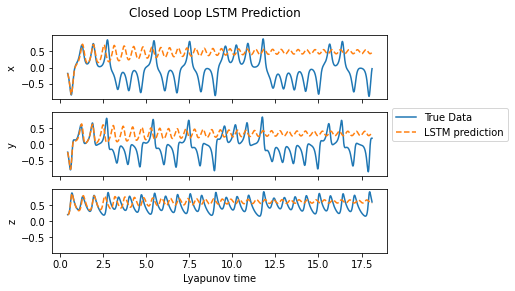

In [30]:
pred_closed_loop = predictions
test_time_end = len(predictions)
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, facecolor="white")#, figsize=(15, 15))
fig.suptitle('Closed Loop LSTM Prediction')
ax1.plot(lyapunov_time[:test_time_end],x_test[50:50+test_time_end], label='True Data')
ax1.plot(lyapunov_time[:test_time_end],pred_closed_loop[:,0],'--', label='RNN Prediction')
ax1.set_ylabel('x')

ax2.plot(lyapunov_time[:test_time_end],y_test[50:50+test_time_end], label='data')
ax2.plot(lyapunov_time[:test_time_end],pred_closed_loop[:,1],'--', label='RNN prediction on test data')
ax2.set_ylabel('y')
ax3.plot(lyapunov_time[:test_time_end],z_test[50:50+test_time_end], label='True Data')
ax3.plot(lyapunov_time[:test_time_end],pred_closed_loop[:,2],'--', label='LSTM prediction')
ax3.set_ylabel('z')
ax3.set_xlabel('Lyapunov time')
#ax3.set_ylim(-1,1)
#ax3.set_xlim(0,5)
ax3.legend(loc='center left', bbox_to_anchor=(1, 2.0))
plt.show()
#fig.savefig(lyapunov_path, dpi=1000, facecolor="w", bbox_inches='tight')

In [32]:
def plot_closed_loop_lya(model, n_length=1000):
    test_window = create_window_closed_loop(df_test.transpose(), 0)  # np.append(df_train[:, -50:], df_test, axis=1)
    predictions = model.predict(test_window)
    for iteration in range(1,n_length):
        test_window = create_window_closed_loop(df_test.transpose(), iteration, predictions)
        new_pred = model.predict(test_window)
        predictions = add_new_pred(predictions, new_pred)
    pred_closed_loop = predictions
    test_time_end = len(predictions)
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, facecolor="white")#, figsize=(15, 15))
    fig.suptitle('Closed Loop LSTM Prediction')
    ax1.plot(lyapunov_time[:test_time_end],x_test[50:50+test_time_end], label='True Data')
    ax1.plot(lyapunov_time[:test_time_end],pred_closed_loop[:,0],'--', label='RNN Prediction')
    ax1.set_ylabel('x')

    ax2.plot(lyapunov_time[:test_time_end],y_test[50:50+test_time_end], label='data')
    ax2.plot(lyapunov_time[:test_time_end],pred_closed_loop[:,1],'--', label='RNN prediction on test data')
    ax2.set_ylabel('y')
    ax3.plot(lyapunov_time[:test_time_end],z_test[50:50+test_time_end], label='True Data')
    ax3.plot(lyapunov_time[:test_time_end],pred_closed_loop[:,2],'--', label='LSTM prediction')
    ax3.set_ylabel('z')
    ax3.set_xlabel('Lyapunov time')
    #ax3.set_ylim(-1,1)
    #ax3.set_xlim(0,5)
    ax3.legend(loc='center left', bbox_to_anchor=(1, 2.0))
    plt.show()

no network prediction yet


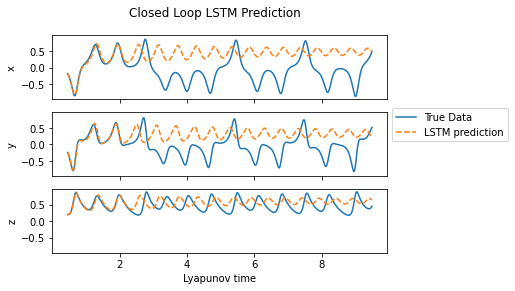

In [33]:
plot_closed_loop_lya(model)